<img src = 'https://media.nationalgeographic.org/assets/photos/000/273/27302_c0-41-990-701_r1050x700.jpg?d4ccf3044d9da0d0118103be3a76bd1319370847' >

## Brief Introduction about Titanic Ship
Titanic was a British passenger liner operated by the White Star Line that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after striking an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking one of modern history's deadliest peacetime commercial marine disasters.
Though there were about 2,224 passengers and crew members, we are given data of about 1,300 passengers. Out of these 1,300 passengers details, about 9000 data is used for training purpose and remaining 400 is used for test purpose. In this competition we are given about 400 test data with missing survived column and we have to use different machine learning algorithms to predict whether the passengers in the test data survived or not.
Both training and test data arenot clean(contains lots of missing values), so main goal of this competition is to clean the data and build the model with best accuracy.

## Understanding the data



Survival : 0 = No, 1 = Yes

Pclass : A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower

sibsp : The # of siblings / spouses aboard the Titanic Sibling = brother, sister, stepbrother, stepsister Spouse = 

husband, wife (mistresses and fiancés were ignored)

parch : The # of parents / children aboard the Titanic Parent = mother, father Child = daughter, son, 
stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.

Ticket : Ticket number

Fare : Passenger fare

Cabin : Cabin number embarked

Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

Name, Sex , Age are self-explanatory



## Importing all necessary libraries


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import enum
import os
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
class Mode(enum.Enum):
    TRAIN = "TRAIN"
    TEST = "TEST"

## Define the current run-mode

In [3]:
import platform

PC_NAME = platform.node().replace(" ", "_").replace(".", "_")
MODEL_DIR = f"../../output/titanic/models/{PC_NAME}"
MODE = Mode.TEST
if MODE == Mode.TEST and not os.path.exists(MODEL_DIR):
    print(f"Error: model not created (path \"{MODEL_DIR}\" does not exist), mode will be Mode.TRAIN")
    MODE = Mode.TRAIN

"### Load the data

In [4]:
train_data = pd.read_csv('../../input/titanic/train.csv')
test_data = pd.read_csv('../../input/titanic/test.csv')

# Dealing with the Missing values

In [5]:
# before filling the missing values, let's drop Cabin column from both data.
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

In [6]:
combined_data = [train_data, test_data]
for data in combined_data:
    print(data.isnull().sum())
    print('*' * 20)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64
********************
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64
********************


In [7]:
# filling the nan values fo Age and fare column with the mean while Embarked column with most_frequent value
for data in combined_data:
    data.Age.fillna(data.Age.mean(), inplace=True)
    data.Fare.fillna(data.Fare.mean(), inplace=True)

# from visualization we know that Southamptom is most frequent Embarked place so, filling the missing value 
# with 'S'
train_data.Embarked.fillna('S', inplace=True)

## Converting a categorical feature¶



##### Let's  start by converting Sex feature to categorical  female=1 and male=0

In [8]:
def change_gender(x):
    if x == 'male':
        return 0
    elif x == 'female':
        return 1


train_data.Sex = train_data.Sex.apply(change_gender)
test_data.Sex = test_data.Sex.apply(change_gender)

**using map funcion to change the Embarked column S = 1, C = 2, Q = 0**

In [9]:
change = {'S': 1, 'C': 2, 'Q': 0}
train_data.Embarked = train_data.Embarked.map(change)
test_data.Embarked = test_data.Embarked.map(change)

# Feature Extraction


while visualizing the correlation heatmap we came to know that Sibsp and Parch columns were closely related 
so lets created new column called Alone using this two columns
-------> 1 = Alone , 0 = not Alone

In [10]:
train_data['Alone'] = train_data.SibSp + train_data.Parch
test_data['Alone'] = test_data.SibSp + test_data.Parch

train_data.Alone = train_data.Alone.apply(lambda x: 1 if x == 0 else 0)
test_data.Alone = test_data.Alone.apply(lambda x: 1 if x == 0 else 0)

In [11]:
# now lets drop SibSp and Parch column for both training and testing data
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Creating new feature Title extracting from existing feature Name


In [12]:
train_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False).unique().size

17

In [13]:
# lets create the Title feature which contain the title of the passenger and drop Name column
for data in combined_data:
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
    data.drop('Name', axis=1, inplace=True)

In [14]:
train_data.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [15]:
test_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [16]:
#lets replace least occuring title in the data with rare
least_occuring = ['Don', 'Rev', 'Dr', 'Mme', 'Ms',
                  'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Dona',
                  'Jonkheer']
for data in combined_data:
    data.Title = data.Title.replace(least_occuring, 'Rare')

In [17]:
# lets perform title mapping in order to change to ordinal
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for data in combined_data:
    data['Title'] = data['Title'].map(title_mapping)

# Dropping PassengerId and Ticket column

In [18]:
columns_to_drop = ['PassengerId', 'Ticket']
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop[1], axis=1, inplace=True)

## Binning Age and Fare columns

In [19]:
for dataset in combined_data:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [20]:
for data in combined_data:
    data.loc[data['Fare'] < 30, 'Fare'] = 1
    data.loc[(data['Fare'] >= 30) & (data['Fare'] < 50), 'Fare'] = 2
    data.loc[(data['Fare'] >= 50) & (data['Fare'] < 100), 'Fare'] = 3
    data.loc[(data['Fare'] >= 100), 'Fare'] = 4

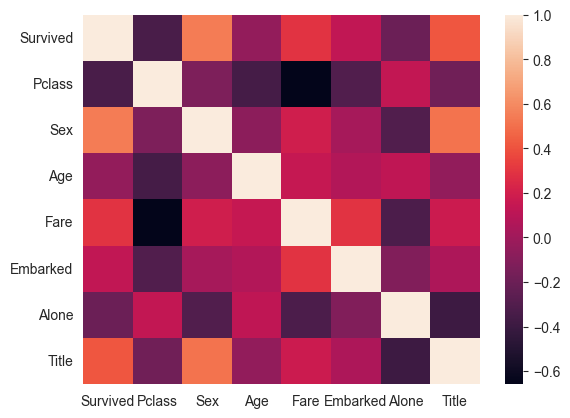

In [21]:
corr_train = train_data.corr()
sns.heatmap(corr_train)
plt.show()

# preparing training and testing data

In [22]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test = test_data.drop("PassengerId", axis=1)

# Neural Network
<img src = 'https://i.imgur.com/mIsGh53.jpg'>

## Import necessary libraries

In [23]:
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential

2023-03-13 13:47:17.394668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Defining model
Here, I have used different number of neurons for each layer and different value for dropout. You can play with these hyperparameter for better outut.

In [40]:
def make_model():
    model = Sequential()
    model.add(Dense(units=16, input_shape=(7,), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(units=32, activation='relu', kernel_initializer='he_normal', use_bias=False))
    model.add(Dense(units=1, activation='sigmoid'))
    return model


model = make_model()

### Model summary

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                128       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                512       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 737
Trainable params: 705
Non-trainable params: 32
_________________________________________________________________


## Compiling and fitting model

In [42]:
if MODE == Mode.TRAIN:
    model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])
    model.fit(X_train, Y_train, batch_size=32, verbose=2, epochs=100)
    model.save(MODEL_DIR)
else:
    model.load_weights(MODEL_DIR)

2023-03-13 13:49:11.884373: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../../output/titanic/models/MacBook-Pro-van-Bo_local: FAILED_PRECONDITION: ../../output/titanic/models/MacBook-Pro-van-Bo_local; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


**Prediction for test data**

In [43]:
predict = model.predict(X_test)
predict = (predict > 0.5).astype(int).ravel()

14/14 [==============================] - 0s 868us/step


# For submission

In [28]:
submit = pd.DataFrame({"PassengerId": test_data.PassengerId, 'Survived': predict})
submit.to_csv("../../output/titanic/death_prediction_per_passenger.csv", index=False)

In [29]:
from sklearn import metrics

Y_pred_rand = (model.predict(X_train) > 0.5).astype(int)
print('Precision : ', np.round(metrics.precision_score(Y_train, Y_pred_rand) * 100, 2))
print('Accuracy : ', np.round(metrics.accuracy_score(Y_train, Y_pred_rand) * 100, 2))
print('Recall : ', np.round(metrics.recall_score(Y_train, Y_pred_rand) * 100, 2))
print('F1 score : ', np.round(metrics.f1_score(Y_train, Y_pred_rand) * 100, 2))
print('AUC : ', np.round(metrics.roc_auc_score(Y_train, Y_pred_rand) * 100, 2))

28/28 [==============================] - 0s 751us/step
Precision :  88.72
Accuracy :  84.74
Recall :  69.01
F1 score :  77.63
AUC :  81.77


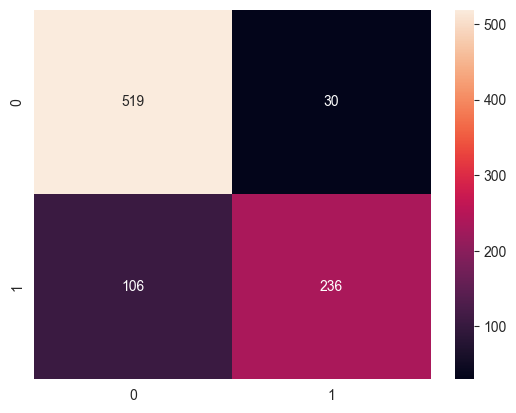

In [30]:
# plotting the confusion matrix in heatmap
matrix = metrics.confusion_matrix(Y_train, Y_pred_rand)
sns.heatmap(matrix, annot=True, fmt='g')
plt.show()

# Co-Activation Graph

14/14 [==============================] - 0s 1ms/step


invalid value encountered in divide
invalid value encountered in divide


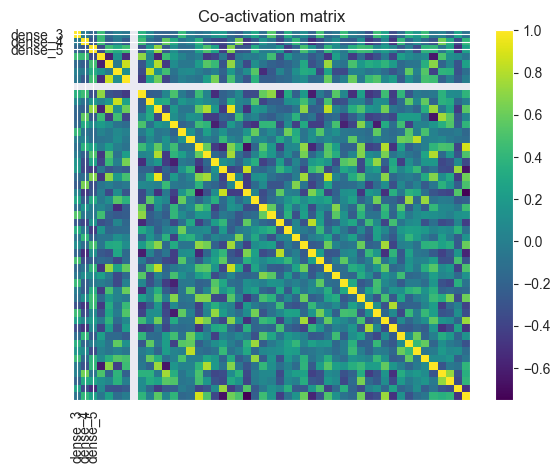

In [76]:
x = X_test

# Compute intermediate layer activations
layer_names = [layer.name for layer in model.layers if 'dense' in layer.name]
outputs = [model.get_layer(name).output for name in layer_names]
model_reduced = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)
activations = model_reduced.predict(x)

# Compute pairwise correlations between activations
activations_flat = np.concatenate([a.reshape(a.shape[0], -1) for a in activations], axis=1)
correlations = np.corrcoef(activations_flat, rowvar=False)

# Plot co-activation matrix
plt.imshow(correlations, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Co-activation matrix')
plt.xticks(np.arange(len(layer_names)), layer_names, rotation=90)
plt.yticks(np.arange(len(layer_names)), layer_names)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


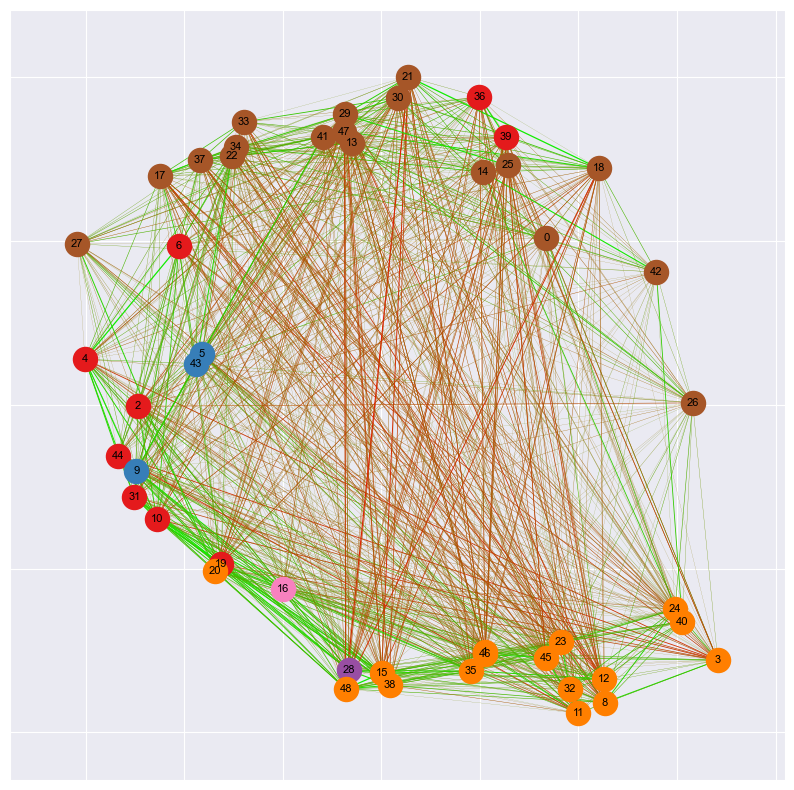

In [65]:
import networkx as nx
import matplotlib.colors as mcolors
from networkx.algorithms.community import louvain_communities

# defines the correlation threshold for the edges (0=everything will be shown, range=(-1,1))
threshold = 0

# Create the graph
G = nx.Graph()
for i in range(correlations.shape[0]):
    for j in range(i + 1, correlations.shape[1]):
        if abs(correlations[i, j]) > threshold:
            G.add_edge(i, j, weight=correlations[i, j])

# Draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(G, weight='weight')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=50)
nx.draw_networkx_labels(G, pos, font_size=8)

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
edges = list(edges)
weights = list(weights)

# this part will do the edge colorization
min_w, max_w = -1, 1
red = mcolors.hex2color('#FF0000')  # red color in RGB format
green = mcolors.hex2color('#00FF00')  # green color in RGB format
edge_colors = []
for w in weights:
    # Map the weight value to a value between 0 and 1
    normalized_w = (w - min_w) / (max_w - min_w)

    # Use a linear interpolation to determine the color between red and green
    color = tuple((1 - normalized_w) * c1 + normalized_w * c2 for c1, c2 in zip(red, green))

    # Convert the color to hexadecimal format and append it to the list
    edge_colors.append(mcolors.rgb2hex(color))

# draw the network edges
edges, weights = zip(*[(edges[i], round(weights[i], 1)) for i in range(len(edges)) if abs(weights[i]) > threshold])
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=weights, edge_cmap=plt.cm.coolwarm, )

# draw the louvain communities
clusters = louvain_communities(G, weight='weight', resolution=2.5)
colors = {}
for i, community in enumerate(clusters):
    color = plt.cm.Set1(i / len(clusters))
    colors.update({node: color for node in community})

for c in clusters:
    nx.draw_networkx_nodes(G, pos, nodelist=list(c), node_color=colors[list(c)[0]], node_size=300)

plt.show()

## SHAP (SHapley Additive exPlanations)

In [ ]:
import shap
import logging

logging.getLogger('shap').setLevel(logging.WARNING)

### Full SHAP

In [ ]:
# This is the full SHAP explainer (begin layer to end layer)
full_explainer = shap.Explainer(model.predict, X_test)
full_shap_values = full_explainer(shap.utils.sample(X_test, 50))
shap.plots.beeswarm(full_shap_values, )

### Clustered SHAP

In [83]:
clusters

[{2, 4, 6, 10, 19, 31, 36, 39, 44},
 {5, 9, 43},
 {28},
 {1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48},
 {0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47},
 {16}]

In [148]:
# this is a function which calculates the aggregated activation for a given cluster and a prediction set
def cluster_activation_aggregation_f(X, cluster: set[int], agg_func=lambda x: sum(x) / len(x)):
    all_a = model_reduced.predict(X)
    all_a = np.concatenate([a.reshape(a.shape[0], -1) for a in all_a], axis=1)
    cluster_activations = []
    for i_a in all_a:
        inst_act = []
        for n_idx, n_a in enumerate(i_a, 1):
            if n_idx in cluster:
                inst_act.append(n_a)
        cluster_activations.append(inst_act)
    print(cluster)
    return np.array([agg_func(y) for y in cluster_activations])

In [160]:
named_clusters = {f"cluster_{i}": c for i, c in enumerate(clusters)}
print(named_clusters)

{'cluster_0': {2, 36, 4, 6, 39, 10, 44, 19, 31}, 'cluster_1': {9, 43, 5}, 'cluster_2': {28}, 'cluster_3': {1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}, 'cluster_4': {0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}, 'cluster_5': {16}}


In [169]:
named_clusters_shaps = {}
for n, c in named_clusters.items():
    ex = shap.Explainer(lambda x: cluster_activation_aggregation_f(x, c), X_test)
    shap_val = ex(shap.utils.sample(X_test, 50))
    named_clusters_shaps[n] = shap_val

161/161 [==============================] - 0s 785us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
156/156 [==============================] - 0s 813us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
16/16 [==============================] - 0s 883us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
274/274 [==============================] - 0s 797us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
20/20 [==============================] - 0s 880us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
295/295 [==============================] - 0s 793us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
19/19 [==============================] - 0s 937us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
139/139 [==============================] - 0s 818us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
19/19 [==============================] - 0s 886us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
131/131 [==============================] - 0s 796us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
14/14 [==============================] - 0s 885us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
138/138 [

Exact explainer:  44%|████▍     | 22/50 [00:00<?, ?it/s]

285/285 [==============================] - 0s 798us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
19/19 [==============================] - 0s 850us/step


Exact explainer:  48%|████▊     | 24/50 [00:11<00:07,  3.28it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
195/195 [==============================] - 0s 797us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
20/20 [==============================] - 0s 864us/step


Exact explainer:  50%|█████     | 25/50 [00:11<00:09,  2.70it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
280/280 [==============================] - 0s 812us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
18/18 [==============================] - 0s 881us/step


Exact explainer:  52%|█████▏    | 26/50 [00:12<00:11,  2.18it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
169/169 [==============================] - 0s 790us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
19/19 [==============================] - 0s 887us/step


Exact explainer:  54%|█████▍    | 27/50 [00:12<00:10,  2.24it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
307/307 [==============================] - 0s 829us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
20/20 [==============================] - 0s 898us/step


Exact explainer:  56%|█████▌    | 28/50 [00:13<00:11,  1.91it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
236/236 [==============================] - 0s 803us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
17/17 [==============================] - 0s 850us/step


Exact explainer:  58%|█████▊    | 29/50 [00:13<00:11,  1.89it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
131/131 [==============================] - 0s 863us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
14/14 [==============================] - 0s 876us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}


Exact explainer:  60%|██████    | 30/50 [00:14<00:09,  2.09it/s]

196/196 [==============================] - 0s 813us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
23/23 [==============================] - 0s 828us/step


Exact explainer:  62%|██████▏   | 31/50 [00:14<00:09,  2.09it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
188/188 [==============================] - 0s 814us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
18/18 [==============================] - 0s 907us/step


Exact explainer:  64%|██████▍   | 32/50 [00:15<00:08,  2.11it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
131/131 [==============================] - 0s 837us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
14/14 [==============================] - 0s 904us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}

Exact explainer:  66%|██████▌   | 33/50 [00:15<00:07,  2.28it/s]


236/236 [==============================] - 0s 817us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
17/17 [==============================] - 0s 922us/step


Exact explainer:  68%|██████▊   | 34/50 [00:15<00:07,  2.13it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
133/133 [==============================] - 0s 842us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
16/16 [==============================] - 0s 887us/step


Exact explainer:  70%|███████   | 35/50 [00:16<00:06,  2.27it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
152/152 [==============================] - 0s 831us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
20/20 [==============================] - 0s 884us/step


Exact explainer:  72%|███████▏  | 36/50 [00:16<00:06,  2.31it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
138/138 [==============================] - 0s 837us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
16/16 [==============================] - 0s 877us/step


Exact explainer:  74%|███████▍  | 37/50 [00:17<00:05,  2.41it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
217/217 [==============================] - 0s 912us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
24/24 [==============================] - 0s 870us/step


Exact explainer:  76%|███████▌  | 38/50 [00:17<00:05,  2.22it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
131/131 [==============================] - 0s 838us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
14/14 [==============================] - 0s 902us/step


Exact explainer:  78%|███████▊  | 39/50 [00:18<00:04,  2.35it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
138/138 [==============================] - 0s 845us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
16/16 [==============================] - 0s 974us/step


Exact explainer:  80%|████████  | 40/50 [00:18<00:04,  2.43it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
131/131 [==============================] - 0s 831us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
14/14 [==============================] - 0s 1ms/step


Exact explainer:  82%|████████▏ | 41/50 [00:19<00:05,  1.76it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
131/131 [==============================] - 0s 895us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
14/14 [==============================] - 0s 903us/step


Exact explainer:  84%|████████▍ | 42/50 [00:19<00:04,  1.96it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
131/131 [==============================] - 0s 839us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
14/14 [==============================] - 0s 963us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}

Exact explainer:  86%|████████▌ | 43/50 [00:20<00:03,  2.14it/s]


158/158 [==============================] - 0s 824us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
16/16 [==============================] - 0s 787us/step


Exact explainer:  88%|████████▊ | 44/50 [00:20<00:02,  2.23it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
131/131 [==============================] - 0s 825us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
14/14 [==============================] - 0s 918us/step


Exact explainer:  90%|█████████ | 45/50 [00:20<00:02,  2.36it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
139/139 [==============================] - 0s 845us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
19/19 [==============================] - 0s 918us/step


Exact explainer:  92%|█████████▏| 46/50 [00:21<00:01,  2.41it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
291/291 [==============================] - 0s 808us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
19/19 [==============================] - 0s 989us/step


Exact explainer:  94%|█████████▍| 47/50 [00:21<00:01,  2.08it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
286/286 [==============================] - 0s 805us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
20/20 [==============================] - 0s 859us/step


Exact explainer:  96%|█████████▌| 48/50 [00:22<00:01,  1.90it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
182/182 [==============================] - 0s 802us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
21/21 [==============================] - 0s 869us/step


Exact explainer:  98%|█████████▊| 49/50 [00:22<00:00,  1.99it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
341/341 [==============================] - 0s 906us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
24/24 [==============================] - 0s 828us/step


Exact explainer: 100%|██████████| 50/50 [00:23<00:00,  1.72it/s]

{2, 36, 4, 6, 39, 10, 44, 19, 31}
287/287 [==============================] - 0s 808us/step
{2, 36, 4, 6, 39, 10, 44, 19, 31}
16/16 [==============================] - 0s 910us/step


Exact explainer: 51it [00:24,  1.19it/s]                        

{2, 36, 4, 6, 39, 10, 44, 19, 31}
161/161 [==============================] - 0s 800us/step


{9, 43, 5}
156/156 [==============================] - 0s 817us/step
{9, 43, 5}
16/16 [==============================] - 0s 886us/step
{9, 43, 5}
274/274 [==============================] - 0s 802us/step
{9, 43, 5}
20/20 [==============================] - 0s 845us/step
{9, 43, 5}
295/295 [==============================] - 0s 805us/step
{9, 43, 5}
19/19 [==============================] - 0s 856us/step
{9, 43, 5}
139/139 [==============================] - 0s 821us/step
{9, 43, 5}
19/19 [==============================] - 0s 904us/step
{9, 43, 5}
131/131 [==============================] - 0s 821us/step
{9, 43, 5}
14/14 [==============================] - 0s 899us/step
{9, 43, 5}
138/138 [==============================] - 0s 816us/step
{9, 43, 5}
16/16 [==============================] - 0s 935us/step
{9, 43, 5}
280/280 [==============================] - 0s 814us/step
{9, 43, 5}
18/18 [==============================] - 0s 889us/step
{9, 43, 5}
161/161 [==============================] - 0s 818us

Exact explainer:  44%|████▍     | 22/50 [00:00<?, ?it/s]

285/285 [==============================] - 0s 826us/step
{9, 43, 5}
19/19 [==============================] - 0s 876us/step


Exact explainer:  48%|████▊     | 24/50 [00:10<00:07,  3.27it/s]

{9, 43, 5}
195/195 [==============================] - 0s 805us/step
{9, 43, 5}
20/20 [==============================] - 0s 878us/step


Exact explainer:  50%|█████     | 25/50 [00:11<00:09,  2.68it/s]

{9, 43, 5}
280/280 [==============================] - 0s 805us/step
{9, 43, 5}
18/18 [==============================] - 0s 849us/step


Exact explainer:  52%|█████▏    | 26/50 [00:12<00:11,  2.18it/s]

{9, 43, 5}
169/169 [==============================] - 0s 801us/step
{9, 43, 5}
19/19 [==============================] - 0s 838us/step


Exact explainer:  54%|█████▍    | 27/50 [00:12<00:10,  2.24it/s]

{9, 43, 5}
307/307 [==============================] - 0s 835us/step
{9, 43, 5}
20/20 [==============================] - 0s 906us/step


Exact explainer:  56%|█████▌    | 28/50 [00:13<00:11,  1.94it/s]

{9, 43, 5}
236/236 [==============================] - 0s 812us/step
{9, 43, 5}
17/17 [==============================] - 0s 857us/step


Exact explainer:  58%|█████▊    | 29/50 [00:13<00:10,  1.92it/s]

{9, 43, 5}
131/131 [==============================] - 0s 833us/step
{9, 43, 5}
14/14 [==============================] - 0s 894us/step


Exact explainer:  60%|██████    | 30/50 [00:13<00:09,  2.13it/s]

{9, 43, 5}
196/196 [==============================] - 0s 834us/step
{9, 43, 5}
23/23 [==============================] - 0s 830us/step


Exact explainer:  62%|██████▏   | 31/50 [00:14<00:09,  2.10it/s]

{9, 43, 5}
188/188 [==============================] - 0s 824us/step
{9, 43, 5}
18/18 [==============================] - 0s 882us/step


Exact explainer:  64%|██████▍   | 32/50 [00:14<00:08,  2.12it/s]

{9, 43, 5}
131/131 [==============================] - 0s 836us/step
{9, 43, 5}
14/14 [==============================] - 0s 886us/step


Exact explainer:  66%|██████▌   | 33/50 [00:15<00:07,  2.29it/s]

{9, 43, 5}
236/236 [==============================] - 0s 813us/step
{9, 43, 5}
17/17 [==============================] - 0s 934us/step


Exact explainer:  68%|██████▊   | 34/50 [00:15<00:07,  2.14it/s]

{9, 43, 5}
133/133 [==============================] - 0s 840us/step
{9, 43, 5}
16/16 [==============================] - 0s 888us/step


Exact explainer:  70%|███████   | 35/50 [00:16<00:06,  2.29it/s]

{9, 43, 5}
152/152 [==============================] - 0s 832us/step
{9, 43, 5}
20/20 [==============================] - 0s 910us/step


Exact explainer:  72%|███████▏  | 36/50 [00:16<00:05,  2.34it/s]

{9, 43, 5}
138/138 [==============================] - 0s 812us/step
{9, 43, 5}
16/16 [==============================] - 0s 1ms/step


Exact explainer:  74%|███████▍  | 37/50 [00:16<00:05,  2.44it/s]

{9, 43, 5}
217/217 [==============================] - 0s 1ms/step
{9, 43, 5}
24/24 [==============================] - 0s 827us/step


Exact explainer:  76%|███████▌  | 38/50 [00:17<00:05,  2.19it/s]

{9, 43, 5}
131/131 [==============================] - 0s 833us/step
{9, 43, 5}
14/14 [==============================] - 0s 917us/step
{9, 43, 5}


Exact explainer:  78%|███████▊  | 39/50 [00:17<00:04,  2.34it/s]

138/138 [==============================] - 0s 859us/step
{9, 43, 5}
16/16 [==============================] - 0s 968us/step


Exact explainer:  80%|████████  | 40/50 [00:18<00:04,  2.42it/s]

{9, 43, 5}
131/131 [==============================] - 0s 841us/step
{9, 43, 5}
14/14 [==============================] - 0s 913us/step


Exact explainer:  82%|████████▏ | 41/50 [00:18<00:03,  2.51it/s]

{9, 43, 5}
131/131 [==============================] - 0s 845us/step
{9, 43, 5}
14/14 [==============================] - 0s 926us/step
{9, 43, 5}


Exact explainer:  84%|████████▍ | 42/50 [00:19<00:03,  2.59it/s]

131/131 [==============================] - 0s 830us/step
{9, 43, 5}
14/14 [==============================] - 0s 854us/step


Exact explainer:  86%|████████▌ | 43/50 [00:19<00:02,  2.64it/s]

{9, 43, 5}
158/158 [==============================] - 0s 832us/step
{9, 43, 5}
16/16 [==============================] - 0s 910us/step


Exact explainer:  88%|████████▊ | 44/50 [00:19<00:02,  2.57it/s]

{9, 43, 5}
131/131 [==============================] - 0s 848us/step
{9, 43, 5}
14/14 [==============================] - 0s 904us/step


Exact explainer:  90%|█████████ | 45/50 [00:20<00:01,  2.63it/s]

{9, 43, 5}
139/139 [==============================] - 0s 812us/step
{9, 43, 5}
19/19 [==============================] - 0s 867us/step


Exact explainer:  92%|█████████▏| 46/50 [00:20<00:01,  2.64it/s]

{9, 43, 5}
291/291 [==============================] - 0s 811us/step
{9, 43, 5}
19/19 [==============================] - 0s 802us/step


Exact explainer:  94%|█████████▍| 47/50 [00:21<00:01,  2.21it/s]

{9, 43, 5}
286/286 [==============================] - 0s 1ms/step
{9, 43, 5}
20/20 [==============================] - 0s 892us/step


Exact explainer:  96%|█████████▌| 48/50 [00:21<00:01,  1.92it/s]

{9, 43, 5}
182/182 [==============================] - 0s 819us/step
{9, 43, 5}
21/21 [==============================] - 0s 891us/step


Exact explainer:  98%|█████████▊| 49/50 [00:22<00:00,  2.00it/s]

{9, 43, 5}
341/341 [==============================] - 0s 897us/step
{9, 43, 5}
24/24 [==============================] - 0s 832us/step


Exact explainer: 100%|██████████| 50/50 [00:23<00:00,  1.73it/s]

{9, 43, 5}
287/287 [==============================] - 0s 809us/step
{9, 43, 5}
16/16 [==============================] - 0s 824us/step


Exact explainer: 51it [00:23,  1.23it/s]                        

{9, 43, 5}
161/161 [==============================] - 0s 815us/step


{28}
156/156 [==============================] - 0s 819us/step
{28}
16/16 [==============================] - 0s 929us/step
{28}
274/274 [==============================] - 0s 809us/step
{28}
20/20 [==============================] - 0s 823us/step
{28}
295/295 [==============================] - 0s 807us/step
{28}
19/19 [==============================] - 0s 891us/step
{28}
139/139 [==============================] - 0s 823us/step
{28}
19/19 [==============================] - 0s 917us/step
{28}
131/131 [==============================] - 0s 807us/step
{28}
14/14 [==============================] - 0s 992us/step
{28}
138/138 [==============================] - 0s 821us/step
{28}
16/16 [==============================] - 0s 968us/step
{28}
280/280 [==============================] - 0s 819us/step
{28}
18/18 [==============================] - 0s 884us/step
{28}
161/161 [==============================] - 0s 802us/step
{28}
16/16 [==============================] - 0s 962us/step
{28}
131/131 [==========

Exact explainer:  44%|████▍     | 22/50 [00:00<?, ?it/s]

285/285 [==============================] - 0s 840us/step
{28}
19/19 [==============================] - 0s 872us/step


Exact explainer:  48%|████▊     | 24/50 [00:10<00:08,  3.18it/s]

{28}
195/195 [==============================] - 0s 814us/step
{28}
20/20 [==============================] - 0s 876us/step


Exact explainer:  50%|█████     | 25/50 [00:11<00:09,  2.65it/s]

{28}
280/280 [==============================] - 0s 844us/step
{28}
18/18 [==============================] - 0s 875us/step


Exact explainer:  52%|█████▏    | 26/50 [00:11<00:11,  2.16it/s]

{28}
169/169 [==============================] - 0s 804us/step
{28}
19/19 [==============================] - 0s 887us/step


Exact explainer:  54%|█████▍    | 27/50 [00:12<00:10,  2.23it/s]

{28}
307/307 [==============================] - 0s 815us/step
{28}
20/20 [==============================] - 0s 913us/step


Exact explainer:  56%|█████▌    | 28/50 [00:13<00:11,  1.95it/s]

{28}
236/236 [==============================] - 0s 814us/step
{28}
17/17 [==============================] - 0s 970us/step


Exact explainer:  58%|█████▊    | 29/50 [00:13<00:10,  1.93it/s]

{28}
131/131 [==============================] - 0s 817us/step
{28}
14/14 [==============================] - 0s 930us/step
{28}

Exact explainer:  60%|██████    | 30/50 [00:13<00:09,  2.14it/s]


196/196 [==============================] - 0s 819us/step
{28}
23/23 [==============================] - 0s 856us/step


Exact explainer:  62%|██████▏   | 31/50 [00:14<00:08,  2.11it/s]

{28}
188/188 [==============================] - 0s 831us/step
{28}
18/18 [==============================] - 0s 923us/step


Exact explainer:  64%|██████▍   | 32/50 [00:14<00:08,  2.14it/s]

{28}
131/131 [==============================] - 0s 814us/step
{28}
14/14 [==============================] - 0s 993us/step
{28}


Exact explainer:  66%|██████▌   | 33/50 [00:15<00:07,  2.31it/s]

236/236 [==============================] - 0s 821us/step
{28}
17/17 [==============================] - 0s 926us/step


Exact explainer:  68%|██████▊   | 34/50 [00:15<00:07,  2.16it/s]

{28}
133/133 [==============================] - 0s 841us/step
{28}
16/16 [==============================] - 0s 917us/step


Exact explainer:  70%|███████   | 35/50 [00:16<00:06,  2.30it/s]

{28}
152/152 [==============================] - 0s 834us/step
{28}
20/20 [==============================] - 0s 859us/step


Exact explainer:  72%|███████▏  | 36/50 [00:16<00:05,  2.36it/s]

{28}
138/138 [==============================] - 0s 813us/step
{28}
16/16 [==============================] - 0s 874us/step


Exact explainer:  74%|███████▍  | 37/50 [00:16<00:05,  2.44it/s]

{28}
217/217 [==============================] - 0s 907us/step
{28}
24/24 [==============================] - 0s 897us/step


Exact explainer:  76%|███████▌  | 38/50 [00:17<00:05,  2.24it/s]

{28}
131/131 [==============================] - 0s 847us/step
{28}
14/14 [==============================] - 0s 924us/step


Exact explainer:  78%|███████▊  | 39/50 [00:17<00:04,  2.38it/s]

{28}
138/138 [==============================] - 0s 827us/step
{28}
16/16 [==============================] - 0s 962us/step


Exact explainer:  80%|████████  | 40/50 [00:18<00:04,  2.46it/s]

{28}
131/131 [==============================] - 0s 828us/step
{28}
14/14 [==============================] - 0s 939us/step


Exact explainer:  82%|████████▏ | 41/50 [00:18<00:03,  2.55it/s]

{28}
131/131 [==============================] - 0s 822us/step
{28}
14/14 [==============================] - 0s 917us/step


Exact explainer:  84%|████████▍ | 42/50 [00:18<00:03,  2.61it/s]

{28}
131/131 [==============================] - 0s 828us/step
{28}
14/14 [==============================] - 0s 880us/step


Exact explainer:  86%|████████▌ | 43/50 [00:19<00:02,  2.66it/s]

{28}
158/158 [==============================] - 0s 841us/step
{28}
16/16 [==============================] - 0s 878us/step


Exact explainer:  88%|████████▊ | 44/50 [00:19<00:02,  2.61it/s]

{28}
131/131 [==============================] - 0s 820us/step
{28}
14/14 [==============================] - 0s 913us/step


Exact explainer:  90%|█████████ | 45/50 [00:19<00:01,  2.66it/s]

{28}
139/139 [==============================] - 0s 845us/step
{28}
19/19 [==============================] - 0s 897us/step


Exact explainer:  92%|█████████▏| 46/50 [00:20<00:01,  2.62it/s]

{28}
291/291 [==============================] - 0s 825us/step
{28}
19/19 [==============================] - 0s 830us/step


Exact explainer:  94%|█████████▍| 47/50 [00:20<00:01,  2.20it/s]

{28}
286/286 [==============================] - 0s 825us/step
{28}
20/20 [==============================] - 0s 868us/step


Exact explainer:  96%|█████████▌| 48/50 [00:21<00:01,  1.99it/s]

{28}
182/182 [==============================] - 0s 797us/step
{28}
21/21 [==============================] - 0s 838us/step


Exact explainer:  98%|█████████▊| 49/50 [00:22<00:00,  2.06it/s]

{28}
341/341 [==============================] - 0s 906us/step
{28}
24/24 [==============================] - 0s 863us/step


Exact explainer: 100%|██████████| 50/50 [00:22<00:00,  1.78it/s]

{28}
287/287 [==============================] - 0s 869us/step
{28}
16/16 [==============================] - 0s 863us/step


Exact explainer: 51it [00:23,  1.21it/s]                        

{28}
161/161 [==============================] - 0s 812us/step


{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
156/156 [==============================] - 0s 824us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
16/16 [==============================] - 0s 857us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
274/274 [==============================] - 0s 815us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
20/20 [==============================] - 0s 852us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
295/295 [==============================] - 0s 812us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
19/19 [==============================] - 0s 895us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
139/139 [==============================] - 0s 823us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
19/19 [==============================] - 0s 863us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46

Exact explainer:  42%|████▏     | 21/50 [00:00<?, ?it/s]

187/187 [==============================] - 0s 835us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
20/20 [==============================] - 0s 886us/step


Exact explainer:  46%|████▌     | 23/50 [00:10<00:06,  4.24it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
285/285 [==============================] - 0s 818us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
19/19 [==============================] - 0s 866us/step


Exact explainer:  48%|████▊     | 24/50 [00:11<00:10,  2.48it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
195/195 [==============================] - 0s 816us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
20/20 [==============================] - 0s 853us/step


Exact explainer:  50%|█████     | 25/50 [00:11<00:10,  2.30it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
280/280 [==============================] - 0s 810us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
18/18 [==============================] - 0s 847us/step


Exact explainer:  52%|█████▏    | 26/50 [00:12<00:11,  2.00it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
169/169 [==============================] - 0s 861us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
19/19 [==============================] - 0s 970us/step


Exact explainer:  54%|█████▍    | 27/50 [00:12<00:11,  2.06it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
307/307 [==============================] - 0s 808us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
20/20 [==============================] - 0s 856us/step


Exact explainer:  56%|█████▌    | 28/50 [00:13<00:11,  1.84it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
236/236 [==============================] - 0s 808us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
17/17 [==============================] - 0s 862us/step


Exact explainer:  58%|█████▊    | 29/50 [00:14<00:11,  1.83it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
131/131 [==============================] - 0s 844us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
14/14 [==============================] - 0s 995us/step


Exact explainer:  60%|██████    | 30/50 [00:14<00:09,  2.03it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
196/196 [==============================] - 0s 828us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
23/23 [==============================] - 0s 813us/step


Exact explainer:  62%|██████▏   | 31/50 [00:14<00:09,  2.03it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
188/188 [==============================] - 0s 819us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
18/18 [==============================] - 0s 846us/step


Exact explainer:  64%|██████▍   | 32/50 [00:15<00:08,  2.06it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
131/131 [==============================] - 0s 849us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
14/14 [==============================] - 0s 936us/step


Exact explainer:  66%|██████▌   | 33/50 [00:15<00:07,  2.22it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
236/236 [==============================] - 0s 828us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
17/17 [==============================] - 0s 935us/step


Exact explainer:  68%|██████▊   | 34/50 [00:16<00:07,  2.07it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
133/133 [==============================] - 0s 831us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
16/16 [==============================] - 0s 1ms/step


Exact explainer:  70%|███████   | 35/50 [00:16<00:06,  2.21it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
152/152 [==============================] - 0s 825us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
20/20 [==============================] - 0s 907us/step


Exact explainer:  72%|███████▏  | 36/50 [00:17<00:06,  2.26it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
138/138 [==============================] - 0s 846us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
16/16 [==============================] - 0s 896us/step


Exact explainer:  74%|███████▍  | 37/50 [00:17<00:05,  2.34it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
217/217 [==============================] - 0s 909us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
24/24 [==============================] - 0s 893us/step


Exact explainer:  76%|███████▌  | 38/50 [00:18<00:05,  2.16it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
131/131 [==============================] - 0s 843us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
14/14 [==============================] - 0s 907us/step


Exact explainer:  78%|███████▊  | 39/50 [00:18<00:04,  2.30it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
138/138 [==============================] - 0s 844us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
16/16 [==============================] - 0s 1ms/step


Exact explainer:  80%|████████  | 40/50 [00:18<00:04,  2.37it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
131/131 [==============================] - 0s 831us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
14/14 [==============================] - 0s 985us/step


Exact explainer:  82%|████████▏ | 41/50 [00:19<00:03,  2.46it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
131/131 [==============================] - 0s 841us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
14/14 [==============================] - 0s 1ms/step


Exact explainer:  84%|████████▍ | 42/50 [00:19<00:03,  2.53it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
131/131 [==============================] - 0s 860us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
14/14 [==============================] - 0s 934us/step


Exact explainer:  86%|████████▌ | 43/50 [00:19<00:02,  2.57it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
158/158 [==============================] - 0s 819us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
16/16 [==============================] - 0s 839us/step


Exact explainer:  88%|████████▊ | 44/50 [00:20<00:02,  2.50it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
131/131 [==============================] - 0s 841us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
14/14 [==============================] - 0s 938us/step


Exact explainer:  90%|█████████ | 45/50 [00:20<00:01,  2.56it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
139/139 [==============================] - 0s 847us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
19/19 [==============================] - 0s 879us/step


Exact explainer:  92%|█████████▏| 46/50 [00:21<00:01,  2.55it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
291/291 [==============================] - 0s 816us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
19/19 [==============================] - 0s 819us/step


Exact explainer:  94%|█████████▍| 47/50 [00:21<00:01,  2.13it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
286/286 [==============================] - 0s 805us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
20/20 [==============================] - 0s 836us/step


Exact explainer:  96%|█████████▌| 48/50 [00:22<00:01,  1.93it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
182/182 [==============================] - 0s 817us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
21/21 [==============================] - 0s 833us/step


Exact explainer:  98%|█████████▊| 49/50 [00:22<00:00,  2.00it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
341/341 [==============================] - 0s 939us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
24/24 [==============================] - 0s 852us/step


Exact explainer: 100%|██████████| 50/50 [00:23<00:00,  1.66it/s]

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
287/287 [==============================] - 0s 814us/step
{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
16/16 [==============================] - 0s 864us/step


Exact explainer: 51it [00:24,  1.23it/s]                        

{1, 3, 8, 11, 12, 15, 20, 23, 24, 32, 35, 38, 40, 45, 46, 48}
161/161 [==============================] - 0s 793us/step


{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
156/156 [==============================] - 0s 817us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
16/16 [==============================] - 0s 891us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
274/274 [==============================] - 0s 807us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
20/20 [==============================] - 0s 819us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
295/295 [==============================] - 0s 806us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
19/19 [==============================] - 0s 880us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
139/139 [==============================] - 0s 808us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
19/19 [========================

Exact explainer:  42%|████▏     | 21/50 [00:00<?, ?it/s]

187/187 [==============================] - 0s 840us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
20/20 [==============================] - 0s 900us/step


Exact explainer:  46%|████▌     | 23/50 [00:10<00:06,  4.10it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
285/285 [==============================] - 0s 825us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
19/19 [==============================] - 0s 912us/step


Exact explainer:  48%|████▊     | 24/50 [00:11<00:10,  2.44it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
195/195 [==============================] - 0s 813us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
20/20 [==============================] - 0s 892us/step


Exact explainer:  50%|█████     | 25/50 [00:11<00:10,  2.29it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
280/280 [==============================] - 0s 822us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
18/18 [==============================] - 0s 837us/step


Exact explainer:  52%|█████▏    | 26/50 [00:12<00:12,  1.98it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
169/169 [==============================] - 0s 811us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
19/19 [==============================] - 0s 931us/step


Exact explainer:  54%|█████▍    | 27/50 [00:12<00:11,  2.07it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
307/307 [==============================] - 0s 816us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
20/20 [==============================] - 0s 850us/step


Exact explainer:  56%|█████▌    | 28/50 [00:13<00:11,  1.83it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
236/236 [==============================] - 0s 810us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
17/17 [==============================] - 0s 860us/step


Exact explainer:  58%|█████▊    | 29/50 [00:14<00:11,  1.82it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
131/131 [==============================] - 0s 842us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
14/14 [==============================] - 0s 868us/step


Exact explainer:  60%|██████    | 30/50 [00:14<00:09,  2.03it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
196/196 [==============================] - 0s 843us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
23/23 [==============================] - 0s 917us/step


Exact explainer:  62%|██████▏   | 31/50 [00:15<00:09,  2.02it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
188/188 [==============================] - 0s 839us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
18/18 [==============================] - 0s 925us/step


Exact explainer:  64%|██████▍   | 32/50 [00:15<00:08,  2.02it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
131/131 [==============================] - 0s 824us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
14/14 [==============================] - 0s 906us/step


Exact explainer:  66%|██████▌   | 33/50 [00:15<00:07,  2.19it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
236/236 [==============================] - 0s 830us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
17/17 [==============================] - 0s 865us/step


Exact explainer:  68%|██████▊   | 34/50 [00:16<00:07,  2.06it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
133/133 [==============================] - 0s 848us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
16/16 [==============================] - 0s 891us/step


Exact explainer:  70%|███████   | 35/50 [00:16<00:06,  2.20it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
152/152 [==============================] - 0s 856us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
20/20 [==============================] - 0s 910us/step


Exact explainer:  72%|███████▏  | 36/50 [00:17<00:06,  2.24it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
138/138 [==============================] - 0s 849us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
16/16 [==============================] - 0s 884us/step


Exact explainer:  74%|███████▍  | 37/50 [00:17<00:05,  2.32it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
217/217 [==============================] - 0s 958us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
24/24 [==============================] - 0s 859us/step


Exact explainer:  76%|███████▌  | 38/50 [00:18<00:05,  2.11it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
131/131 [==============================] - 0s 861us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
14/14 [==============================] - 0s 925us/step


Exact explainer:  78%|███████▊  | 39/50 [00:18<00:04,  2.24it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
138/138 [==============================] - 0s 852us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
16/16 [==============================] - 0s 918us/step


Exact explainer:  80%|████████  | 40/50 [00:19<00:04,  2.30it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
131/131 [==============================] - 0s 873us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
14/14 [==============================] - 0s 890us/step


Exact explainer:  82%|████████▏ | 41/50 [00:19<00:03,  2.39it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
131/131 [==============================] - 0s 863us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
14/14 [==============================] - 0s 914us/step


Exact explainer:  84%|████████▍ | 42/50 [00:19<00:03,  2.45it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
131/131 [==============================] - 0s 871us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
14/14 [==============================] - 0s 964us/step


Exact explainer:  86%|████████▌ | 43/50 [00:20<00:02,  2.49it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
158/158 [==============================] - 0s 831us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
16/16 [==============================] - 0s 840us/step


Exact explainer:  88%|████████▊ | 44/50 [00:20<00:02,  2.45it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
131/131 [==============================] - 0s 824us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
14/14 [==============================] - 0s 1ms/step


Exact explainer:  90%|█████████ | 45/50 [00:20<00:01,  2.50it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
139/139 [==============================] - 0s 853us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
19/19 [==============================] - 0s 864us/step


Exact explainer:  92%|█████████▏| 46/50 [00:21<00:01,  2.50it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
291/291 [==============================] - 0s 829us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
19/19 [==============================] - 0s 882us/step


Exact explainer:  94%|█████████▍| 47/50 [00:22<00:01,  2.10it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
286/286 [==============================] - 0s 867us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
20/20 [==============================] - 0s 828us/step


Exact explainer:  96%|█████████▌| 48/50 [00:22<00:01,  1.84it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
182/182 [==============================] - 0s 819us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
21/21 [==============================] - 0s 821us/step


Exact explainer:  98%|█████████▊| 49/50 [00:23<00:00,  1.91it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
341/341 [==============================] - 0s 911us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
24/24 [==============================] - 0s 872us/step


Exact explainer: 100%|██████████| 50/50 [00:23<00:00,  1.67it/s]

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
287/287 [==============================] - 0s 822us/step
{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
16/16 [==============================] - 0s 865us/step


Exact explainer: 51it [00:24,  1.22it/s]                        

{0, 13, 14, 17, 18, 21, 22, 25, 26, 27, 29, 30, 33, 34, 37, 41, 42, 47}
161/161 [==============================] - 0s 846us/step


{16}
156/156 [==============================] - 0s 830us/step
{16}
16/16 [==============================] - 0s 950us/step
{16}
274/274 [==============================] - 0s 824us/step
{16}
20/20 [==============================] - 0s 834us/step
{16}
295/295 [==============================] - 0s 805us/step
{16}
19/19 [==============================] - 0s 841us/step
{16}
139/139 [==============================] - 0s 822us/step
{16}
19/19 [==============================] - 0s 890us/step
{16}
131/131 [==============================] - 0s 831us/step
{16}
14/14 [==============================] - 0s 935us/step
{16}
138/138 [==============================] - 0s 847us/step
{16}
16/16 [==============================] - 0s 860us/step
{16}
280/280 [==============================] - 0s 831us/step
{16}
18/18 [==============================] - 0s 896us/step
{16}
161/161 [==============================] - 0s 820us/step
{16}
16/16 [==============================] - 0s 948us/step
{16}
131/131 [==========

Exact explainer:  42%|████▏     | 21/50 [00:00<?, ?it/s]

187/187 [==============================] - 0s 836us/step
{16}
20/20 [==============================] - 0s 917us/step


Exact explainer:  46%|████▌     | 23/50 [00:10<00:06,  4.22it/s]

{16}
285/285 [==============================] - 0s 860us/step
{16}
19/19 [==============================] - 0s 860us/step


Exact explainer:  48%|████▊     | 24/50 [00:11<00:10,  2.46it/s]

{16}
195/195 [==============================] - 0s 841us/step
{16}
20/20 [==============================] - 0s 960us/step


Exact explainer:  50%|█████     | 25/50 [00:12<00:10,  2.28it/s]

{16}
280/280 [==============================] - 0s 855us/step
{16}
18/18 [==============================] - 0s 813us/step


Exact explainer:  52%|█████▏    | 26/50 [00:12<00:12,  1.97it/s]

{16}
169/169 [==============================] - 0s 846us/step
{16}
19/19 [==============================] - 0s 911us/step


Exact explainer:  54%|█████▍    | 27/50 [00:13<00:11,  2.06it/s]

{16}
307/307 [==============================] - 0s 865us/step
{16}
20/20 [==============================] - 0s 827us/step


Exact explainer:  56%|█████▌    | 28/50 [00:13<00:12,  1.81it/s]

{16}
236/236 [==============================] - 0s 861us/step
{16}
17/17 [==============================] - 0s 911us/step


Exact explainer:  58%|█████▊    | 29/50 [00:14<00:11,  1.80it/s]

{16}
131/131 [==============================] - 0s 847us/step
{16}
14/14 [==============================] - 0s 973us/step


Exact explainer:  60%|██████    | 30/50 [00:14<00:09,  2.01it/s]

{16}
196/196 [==============================] - 0s 871us/step
{16}
23/23 [==============================] - 0s 911us/step


Exact explainer:  62%|██████▏   | 31/50 [00:15<00:09,  2.00it/s]

{16}
188/188 [==============================] - 0s 912us/step
{16}
18/18 [==============================] - 0s 997us/step


Exact explainer:  64%|██████▍   | 32/50 [00:15<00:08,  2.01it/s]

{16}
131/131 [==============================] - 0s 876us/step
{16}
14/14 [==============================] - 0s 984us/step


Exact explainer:  66%|██████▌   | 33/50 [00:16<00:07,  2.17it/s]

{16}
236/236 [==============================] - 0s 904us/step
{16}
17/17 [==============================] - 0s 942us/step


Exact explainer:  68%|██████▊   | 34/50 [00:16<00:07,  2.03it/s]

{16}
133/133 [==============================] - 0s 912us/step
{16}
16/16 [==============================] - 0s 901us/step


Exact explainer:  70%|███████   | 35/50 [00:17<00:06,  2.17it/s]

{16}
152/152 [==============================] - 0s 937us/step
{16}
20/20 [==============================] - 0s 944us/step


Exact explainer:  72%|███████▏  | 36/50 [00:17<00:06,  2.22it/s]

{16}
138/138 [==============================] - 0s 1ms/step
{16}
16/16 [==============================] - 0s 858us/step


Exact explainer:  74%|███████▍  | 37/50 [00:17<00:05,  2.28it/s]

{16}
217/217 [==============================] - 0s 958us/step
{16}
24/24 [==============================] - 0s 810us/step


Exact explainer:  76%|███████▌  | 38/50 [00:18<00:05,  2.11it/s]

{16}
131/131 [==============================] - 0s 942us/step
{16}
14/14 [==============================] - 0s 917us/step


Exact explainer:  78%|███████▊  | 39/50 [00:18<00:04,  2.24it/s]

{16}
138/138 [==============================] - 0s 897us/step
{16}
16/16 [==============================] - 0s 958us/step


Exact explainer:  80%|████████  | 40/50 [00:19<00:04,  2.33it/s]

{16}
131/131 [==============================] - 0s 896us/step
{16}
14/14 [==============================] - 0s 927us/step


Exact explainer:  82%|████████▏ | 41/50 [00:19<00:03,  2.42it/s]

{16}
131/131 [==============================] - 0s 1ms/step
{16}
14/14 [==============================] - 0s 1ms/step


Exact explainer:  84%|████████▍ | 42/50 [00:20<00:03,  2.40it/s]

{16}
131/131 [==============================] - 0s 1ms/step
{16}
14/14 [==============================] - 0s 957us/step


Exact explainer:  86%|████████▌ | 43/50 [00:20<00:02,  2.42it/s]

{16}
158/158 [==============================] - 0s 879us/step
{16}
16/16 [==============================] - 0s 914us/step


Exact explainer:  88%|████████▊ | 44/50 [00:20<00:02,  2.41it/s]

{16}
131/131 [==============================] - 0s 863us/step
{16}
14/14 [==============================] - 0s 956us/step


Exact explainer:  90%|█████████ | 45/50 [00:21<00:02,  2.50it/s]

{16}
139/139 [==============================] - 0s 873us/step
{16}
19/19 [==============================] - 0s 909us/step


Exact explainer:  92%|█████████▏| 46/50 [00:21<00:01,  2.51it/s]

{16}
291/291 [==============================] - 0s 915us/step
{16}
19/19 [==============================] - 0s 949us/step


Exact explainer:  94%|█████████▍| 47/50 [00:22<00:01,  2.06it/s]

{16}
286/286 [==============================] - 0s 825us/step
{16}
20/20 [==============================] - 0s 799us/step


Exact explainer:  96%|█████████▌| 48/50 [00:23<00:01,  1.87it/s]

{16}
182/182 [==============================] - 0s 832us/step
{16}
21/21 [==============================] - 0s 870us/step


Exact explainer:  98%|█████████▊| 49/50 [00:23<00:00,  1.95it/s]

{16}
341/341 [==============================] - 0s 938us/step
{16}
24/24 [==============================] - 0s 883us/step


Exact explainer: 100%|██████████| 50/50 [00:24<00:00,  1.69it/s]

{16}
287/287 [==============================] - 0s 807us/step
{16}
16/16 [==============================] - 0s 869us/step


Exact explainer: 51it [00:24,  1.20it/s]                        

{16}


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


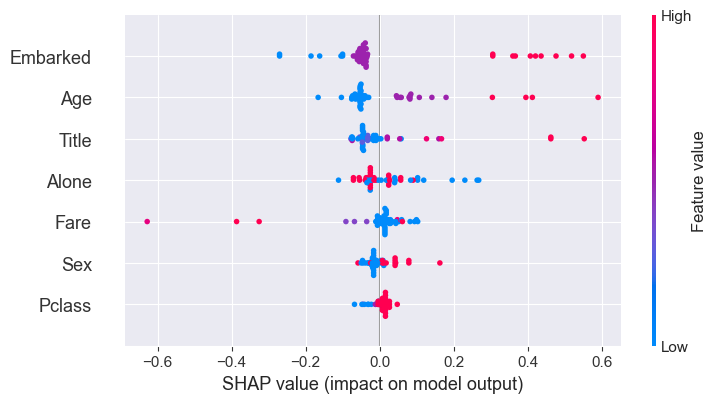

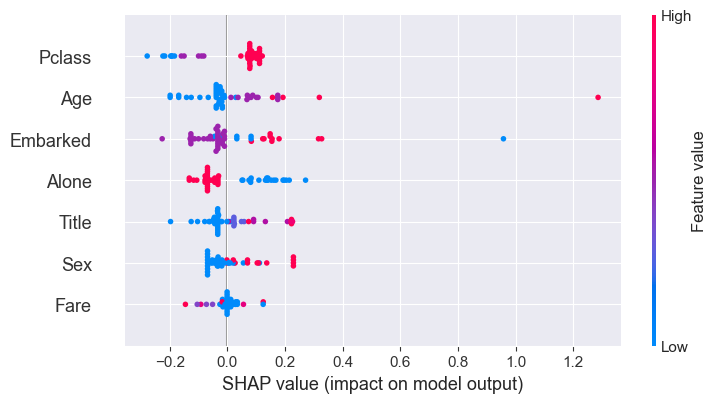

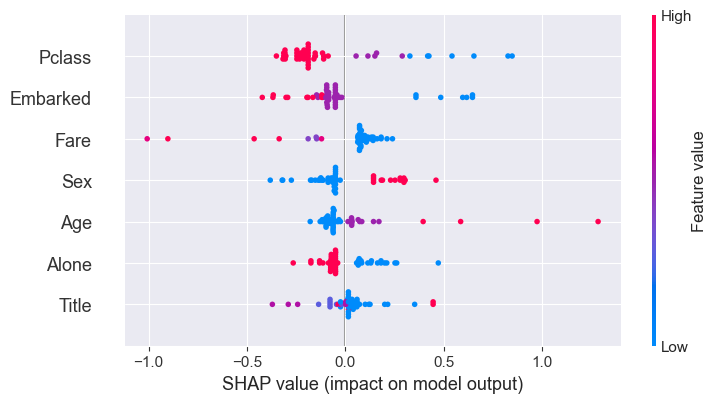

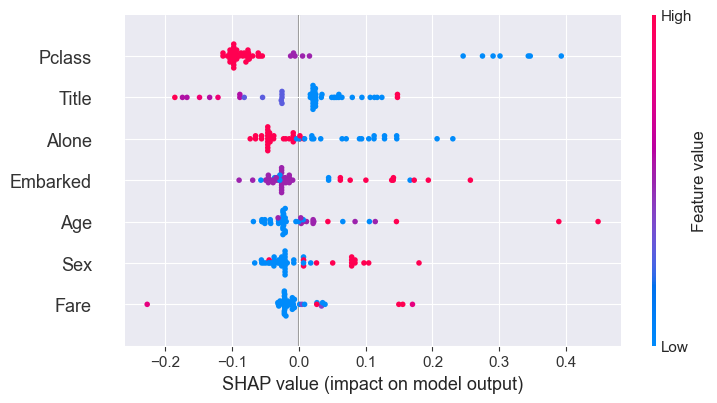

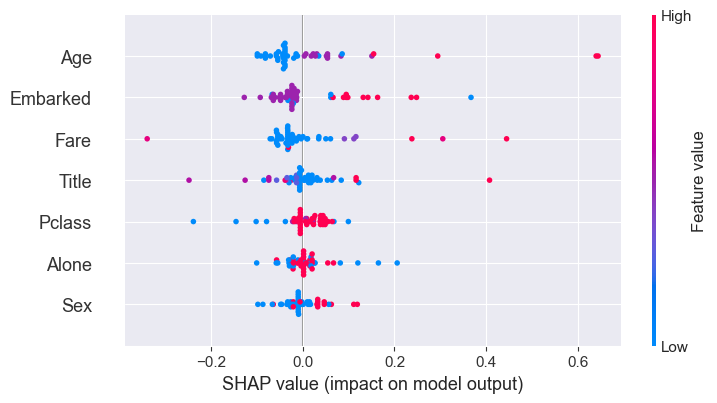

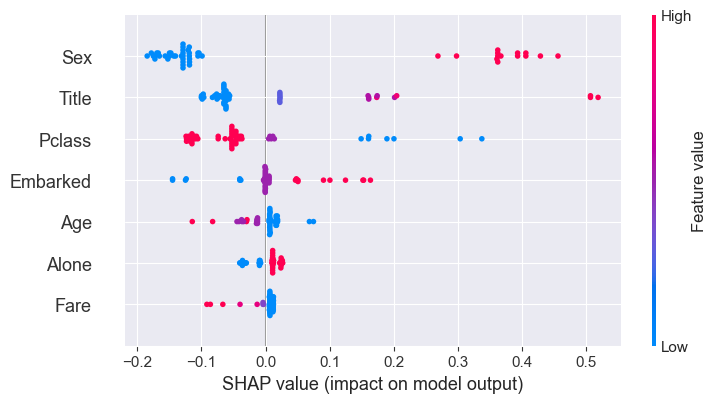

In [170]:
for name, sv in named_clusters_shaps.items():
    shap.plots.beeswarm(sv)